# Band Importance

## Goal

The goal of the first experiment is to find the best combination of bands. We choose from all bands available in the Sentinel-2 [Level-2A](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) product and all indices derived from those bands offered by the [eemont](https://github.com/davemlz/eemont) package.

## Methodology

The experiment is conducted as follows:

- A composite raster with all bands is created by averaging across a 1 year long time window, starting with April 1st, 2017
- Random Forest from scikit-learn with default parameters is chosen as the regression model.
- The 30 best bands are selected using Recursive Feature Elimination (RFE)

We start with listing all available bands and indices:

In [1]:
# List all available Sentinel-2 Level-2A bands
from ltm.data import list_bands

bands = list_bands()

bands

Initializing Earth Engine API...


['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B11',
 'B12',
 'AOT',
 'WVP',
 'SCL',
 'TCI_R',
 'TCI_G',
 'TCI_B',
 'MSK_CLDPRB',
 'MSK_SNWPRB',
 'QA10',
 'QA20',
 'QA60']

In [2]:
# List all available indices offered by eemont
from ltm.data import list_indices

indices = list_indices()

indices

['AFRI1600',
 'AFRI2100',
 'ANDWI',
 'ARI',
 'ARI2',
 'ARVI',
 'ATSAVI',
 'AVI',
 'AWEInsh',
 'AWEIsh',
 'BAI',
 'BAIM',
 'BAIS2',
 'BCC',
 'BI',
 'BITM',
 'BIXS',
 'BLFEI',
 'BNDVI',
 'BRBA',
 'BWDRVI',
 'BaI',
 'CIG',
 'CIRE',
 'CSI',
 'CVI',
 'DBSI',
 'DSI',
 'DSWI1',
 'DSWI2',
 'DSWI3',
 'DSWI4',
 'DSWI5',
 'DVI',
 'DVIplus',
 'EMBI',
 'EVI',
 'EVI2',
 'ExG',
 'ExGR',
 'ExR',
 'FCVI',
 'GARI',
 'GBNDVI',
 'GCC',
 'GDVI',
 'GEMI',
 'GLI',
 'GM1',
 'GM2',
 'GNDVI',
 'GOSAVI',
 'GRNDVI',
 'GRVI',
 'GSAVI',
 'GVMI',
 'IAVI',
 'IBI',
 'IKAW',
 'IPVI',
 'IRECI',
 'LSWI',
 'MBI',
 'MBWI',
 'MCARI',
 'MCARI1',
 'MCARI2',
 'MCARI705',
 'MCARIOSAVI',
 'MCARIOSAVI705',
 'MGRVI',
 'MIRBI',
 'MLSWI26',
 'MLSWI27',
 'MNDVI',
 'MNDWI',
 'MNLI',
 'MRBVI',
 'MSAVI',
 'MSI',
 'MSR',
 'MSR705',
 'MTCI',
 'MTVI1',
 'MTVI2',
 'MuWIR',
 'NBAI',
 'NBR',
 'NBR2',
 'NBRSWIR',
 'NBRplus',
 'NBSIMS',
 'ND705',
 'NDBI',
 'NDCI',
 'NDDI',
 'NDGI',
 'NDGlaI',
 'NDII',
 'NDMI',
 'NDPI',
 'NDPonI',
 'NDREI',
 'ND

We create a raster for the study area with all bands listed above:

In [3]:
# Create a composite from a Sentinel image with all available bands and indices
from ltm.data import sentinel_composite
from datetime import datetime
from pathlib import Path

# Define the label path as well as the path to write the raster to
target_path = "../data/processed/target.tif"
data_path = "../data/processed/band_importance/data.tif"
Path(data_path).parent.mkdir(parents=True, exist_ok=True)

# Create the composite if it does not exist
if not Path(data_path).exists():
    sentinel_composite(
        target_path_from=target_path,
        data_path_to=data_path,
        time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
        indices=indices,
        sentinel_bands=bands,
    )

Now we perform recursive feature elimination to determine the best combination of bands and indices:

In [4]:
# Compute the scores for each step of the RFE
from ltm.data import split_band_name
from ltm.features import load_raster
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_validate

import pandas as pd
from tqdm.notebook import tqdm

# Check if the report is already available
band_importance_path = "../reports/band_importance.csv"
if not Path(band_importance_path).exists():
    Path(band_importance_path).parent.mkdir(parents=True, exist_ok=True)

    # Load the raster, label and drop rows with NaN label
    data = load_raster(data_path)
    target = load_raster(target_path)
    data, target = data[target.notna()], target[target.notna()]

    # Create the RFE object and rank each pixel
    rf = RandomForestRegressor(n_jobs=-1, random_state=42)
    rfe = RFE(estimator=rf, n_features_to_select=1, step=1, verbose=1)
    rfe.fit(data, target)

    # Define the scoring metrics
    scoring = {"Root Mean Squared Error": make_scorer(root_mean_squared_error)}

    # Get the features in reverse order of elimination
    ranking = rfe.ranking_
    feature_names = rfe.feature_names_in_
    order_index = ranking.argsort()
    ordered_features = feature_names[order_index]

    # Compute the score for each step of the RFE
    score_df = pd.DataFrame(columns=scoring.keys())
    for i in tqdm(range(ordered_features.shape[0])):
        # Fit the model with the current features
        curr_data = data[ordered_features[: i + 1]]
        random_forest = RandomForestRegressor(n_jobs=-1, random_state=42)
        scores = cross_validate(
            random_forest, curr_data, target, scoring=scoring, n_jobs=-1
        )

        # Store the score in the dataframe
        band_label = split_band_name(ordered_features[i])[1]
        score_df.loc[band_label] = [
            scores[f"test_{key}"].mean() for key in scoring.keys()
        ]

    # Save the scores to a CSV file
    score_df.to_csv(band_importance_path, index_label="Band")
    score_df.index.name = "Band"
else:
    # Load the scores from the CSV file
    score_df = pd.read_csv(band_importance_path, index_col=0)

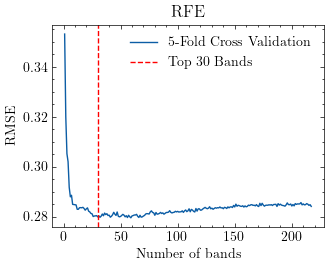

In [5]:
# Plot the RFE scores for n bandsimport matplotlib.pyplot as plt^
import matplotlib.pyplot as plt
import scienceplots

# Use science style for plots
plt.style.use("science")

# Plot RFE scores
score_df["Index"] = range(1, score_df.shape[0] + 1)
ax = score_df.plot(x="Index", y="Root Mean Squared Error", label="5-Fold Cross Validation")
ax.axvline(30, color="red", linestyle="--", label="Top 30 Bands")

# Format the plot
ax.set_title("RFE")
ax.set_xlabel("Number of bands")
ax.set_ylabel("RMSE")
ax.legend()

plt.show()

# Result

The RMSE does not decrease significantly when keeping more 30 bands, see above. Additionally we generally want to keep the number of bands as low as possible to reduce the complexity of data retrieval. Thus we choose following 30 best bands and indices for subsequent experiments:

In [6]:
# List all selected bands and indices
from ltm.models import bands_from_importance

sentinel_bands, index_bands = bands_from_importance(band_importance_path)

sentinel_bands, index_bands

(['B9', 'WVP', 'TCI_G'],
 ['BAIM',
  'BWDRVI',
  'GCC',
  'MCARI705',
  'MIRBI',
  'MLSWI26',
  'MNLI',
  'MTCI',
  'MuWIR',
  'NBRplus',
  'NDDI',
  'NDGI',
  'NSDSI1',
  'NormR',
  'RGRI',
  'S2WI',
  'SIPI',
  'TRRVI',
  'TTVI',
  'VI700',
  'VIBI',
  'WI2',
  'WI2015',
  'kEVI',
  'kIPVI',
  'kNDVI',
  'mSR705'])